### Now that we have finished our federated training, we need to visualize validation results after each run and compare the performances of federated learning and centralized learning. 

Following steps are followed: 
1. prepare data for centralized model; 
2. train centralized model; 
3. plot performance of both models. 

####Import dependencies

In [9]:
import warnings
warnings.simplefilter(action='ignore')
import keras
from keras.models import Sequential
import pandas as pd
from keras.layers import Dropout, Dense, Activation
from keras.layers.recurrent import LSTM
import numpy
import random
import matplotlib.pyplot as plt

####Data preparation

In [10]:
def read_data(filename):
    data = numpy.array(pd.read_csv(filename))
    train = data[0:int(0.8 * data.shape[0]), :]
    test = data[int(0.8 * data.shape[0]):data.shape[0], :]

    trainx = train[:, :-1]
    trainy = train[:, -1]

    testx = test[:, :-1]
    testy = test[:, -1]

    def normalize(X):
        X = X.reshape((X.shape[0], X.shape[1], 1))
        X = X.astype('float32')
        X /= 255
        return X

    trainx = normalize(trainx)
    testx = normalize(testx)

    return (trainx, trainy), (testx, testy)

####Model defining

In [11]:
def define_model():
	model = Sequential()
	layers = [1, 50, 100, 1]
	model.add(LSTM(
		layers[1],
		input_shape=(None, 1),
		return_sequences=True))
	model.add(Dropout(0.2))
	model.add(LSTM(
		layers[2],
		return_sequences=False))
	model.add(Dropout(0.2))
	model.add(Dense(
		layers[3]))
	model.add(Activation("linear"))
	model.compile(loss="mse", optimizer=keras.optimizers.Adam(), metrics=['mae'])
	return model

####Function for training

In [12]:
def centralized_learn(model, trainX, trainY, testX, testY):
    bs = 32
    model.fit(trainX, trainY, epochs=1, batch_size=bs, verbose=0)
    _, mae = model.evaluate(testX, testY, verbose=0)
    return mae

####Function to run centralized training

In [13]:
def run(num_run):
    (trainx, trainy), (testx, testy) = read_data("../data/all_data.csv")
    model = define_model()
    history = list()
    train_fraction = 0.1
    for i in range(num_run):
        print(i)
        samples = random.sample(range(trainy.shape[0]), int(train_fraction * trainy.shape[0]))
        part_trainx = trainx[samples,]
        part_trainy = trainy[samples]
        history.append(centralized_learn(model, part_trainx,
                                         part_trainy, testx, testy))
        ##print(history[i])
    return numpy.array(history)

####Function to load result of federated learning

In [14]:
def read_fed_rslt():
    data = numpy.array(pd.read_csv("../data/val_result/validate.txt", header = None))
    data = data.reshape(int(data.shape[0]/5), 5)
    return data.mean(axis = 1)

####Function to plot federated and centralized learning results
To save the figure, comment ``plt.show()`` and uncomment ``plot.savefig()``

In [15]:
def plot(cent_data, fed_data):
    plt.plot(cent_data, label="Centralized")
    plt.plot(fed_data, label="Federated")
    plt.xlabel('Num of runs')
    plt.ylabel('MAE/celsius')
    plt.title('Minimum temperature in Melbourne: MAE ~ num of runs')
    plt.legend(loc=1)
    ##plt.ylim(20, 100)
    plt.show()
    ##plt.savefig('plot.png')

####To get comparison figure

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65


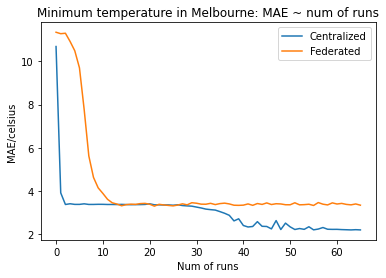

In [16]:
fed_result = read_fed_rslt()
cent_result = run(fed_result.shape[0])
plot(cent_result, fed_result)